In [3]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
model_basepath = "/vol/ideadata/ed52egek/pycharm/privatis_us/archive/DynamicLSBest"
synthetic_latent_path = "/vol/ideadata/at70emic/projects/TMI23/samples/lidm_vpred/checkpoint-380000/ddim_64_100k/latents"
private_latents_output_path = "/vol/ideadata/ed52egek/dynamic/outputs"
DEBUG = False

training_latents_csv = "/vol/ideadata/at70emic/projects/TMI23/data/diffusion/dynamic/FileList.csv"
training_latents_basepath = "/vol/ideadata/at70emic/projects/TMI23/data/diffusion/dynamic/Latents"

In [4]:
import matplotlib.pyplot as plt
import os
from torch.utils import data
import torch
import pandas as pd
import numpy as np
import random
from PIL import Image
PHASE_TO_SPLIT = {"training": "TRAIN", "validation": "VAL", "testing": "TEST"}

class SimaseUSVideoDataset(data.Dataset):
    def __init__(self, 
                 phase='training', 
                 transform=None,
                 latents_csv='./', 
                 training_latents_base_path="./", 
                 in_memory=True, 
                 generator_seed=None):
        self.phase = phase
        self.training_latents_base_path = training_latents_base_path

        self.in_memory = in_memory
        self.videos = []

        self.df = pd.read_csv(latents_csv)
        self.df = self.df[self.df["Split"] == PHASE_TO_SPLIT[self.phase]].reset_index(drop=True)

        self.transform = transform

        if generator_seed is None: 
            self.generator = np.random.default_rng() 
            #unseeded
        else:             
            self.generator_seed = generator_seed
            print(f"Set {self.phase} dataset seed to {self.generator_seed}")

        if self.in_memory: 
            self.load_videos()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        vid_a = self.get_vid(index)
        if self.transform is not None:
            vid_a = self.transform(vid_a)
        return vid_a

    def reset_generator(self): 
        self.generator = np.random.default_rng(self.generator_seed) 

    def get_vid(self, index, from_disk=False): 
        if self.in_memory and not from_disk: 
            return self.videos[index]
        else: 
            return torch.load(os.path.join(self.training_latents_base_path, self.df.iloc[index]["FileName"] + ".pt"))

    def load_videos(self): 
        self.videos = []
        print("Preloading videos")
        for i in range(len(self)):
            self.videos.append(self.get_vid(i, from_disk=True))

normalization =lambda x: (x  - x.min())/(x.max() - x.min()) * 2 - 1  # should be -1 to 1 due to way we trained the model
ds_train = SimaseUSVideoDataset(phase="training", transform=normalization, latents_csv=training_latents_csv, training_latents_base_path=training_latents_basepath, in_memory=False)
ds_test = SimaseUSVideoDataset(phase="testing", transform=normalization, latents_csv=training_latents_csv, training_latents_base_path=training_latents_basepath, in_memory=False)

In [5]:
import os
import torch

synthetic_images_paths = [x for x in os.listdir(synthetic_latent_path)]
if DEBUG: 
    synthetic_images_paths = synthetic_images_paths[:500]

synthetic_images = [torch.load(os.path.join(synthetic_latent_path, x)) for x in synthetic_images_paths]
if DEBUG: 
    synthetic_images = [x[0] for x in synthetic_images]

# convert images to 1 x C x H x W to be consistent in case we want to check videos 
for i in range(len(synthetic_images)): 
    if len(synthetic_images[i].size()) == 3: 
        synthetic_images[i] = synthetic_images[i].unsqueeze(dim=0)

synthetic_images = normalization(torch.cat(synthetic_images))
print(f"Number of synthetic images found: {len(synthetic_images)}")


Number of synthetic images found: 100000


In [7]:
import torch
import torch.nn as nn
import torchvision.models as models


class SiameseNetwork(nn.Module):
    def __init__(self, network='ResNet-50', in_channels=3, n_features=128):
        super(SiameseNetwork, self).__init__()
        self.network = network
        self.in_channels = in_channels
        self.n_features = n_features

        if self.network == 'ResNet-50':
            # Model: Use ResNet-50 architecture
            self.model = models.resnet50(pretrained=True)
            # Adjust the input layer: either 1 or 3 input channels
            if self.in_channels == 1:
                self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            if self.in_channels == 4: 
                self.model.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            elif self.in_channels == 3:
                pass
            else:
                raise Exception(
                    'Invalid argument: ' + self.in_channels + '\nChoose either in_channels=1 or in_channels=3')
            # Adjust the ResNet classification layer to produce feature vectors of a specific size
            self.model.fc = nn.Linear(in_features=2048, out_features=self.n_features, bias=True)

        else:
            raise Exception('Invalid argument: ' + self.network +
                            '\nChoose ResNet-50! Other architectures are not yet implemented in this framework.')

        self.fc_end = nn.Linear(self.n_features, 1)

    def forward_once(self, x):

        # Forward function for one branch to get the n_features-dim feature vector before merging
        output = self.model(x)
        output = torch.sigmoid(output)
        return output

    def forward(self, input1, input2):

        # Forward
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # Compute the absolute difference between the n_features-dim feature vectors and pass it to the last FC-Layer
        difference = torch.abs(output1 - output2)
        output = self.fc_end(difference)

        return output

import json
with open(os.path.join(model_basepath, "config.json")) as config:
    config = config.read()
# parse config
config = json.loads(config)
net = SiameseNetwork(network=config['siamese_architecture'], in_channels=config['n_channels'], n_features=config['n_features'])
best_name = [x for x in os.listdir(model_basepath) if x.endswith("best_network.pth")][0]
net.load_state_dict(torch.load(os.path.join(model_basepath, best_name)))
    

<All keys matched successfully>

In [8]:
from tqdm import tqdm
import numpy as np
net.eval()
net = net.cuda()
bs = 256

# data
latent_train_video = ds_test[1]
synthetic_image = synthetic_images[0]

latents_train = []
latents_test = []
latents_synth = []
with torch.no_grad():
    for i in tqdm(np.arange(0, len(latent_train_video), bs), "Computing Train Embeddings"):
        batch = latent_train_video[i:i+bs].cuda()
        latents_train.append(net.forward_once(batch))

    latents_synth.append(net.forward_once(synthetic_image.unsqueeze(dim=0)))    

latents_train = torch.cat(latents_train)
#latents_test = torch.cat(latents_test)
latents_synth = torch.cat(latents_synth)


Computing Train Embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


In [9]:
train_val_corr_orig = torch.corrcoef(torch.cat([latents_train, latents_synth])).cpu()

torch.Size([200])


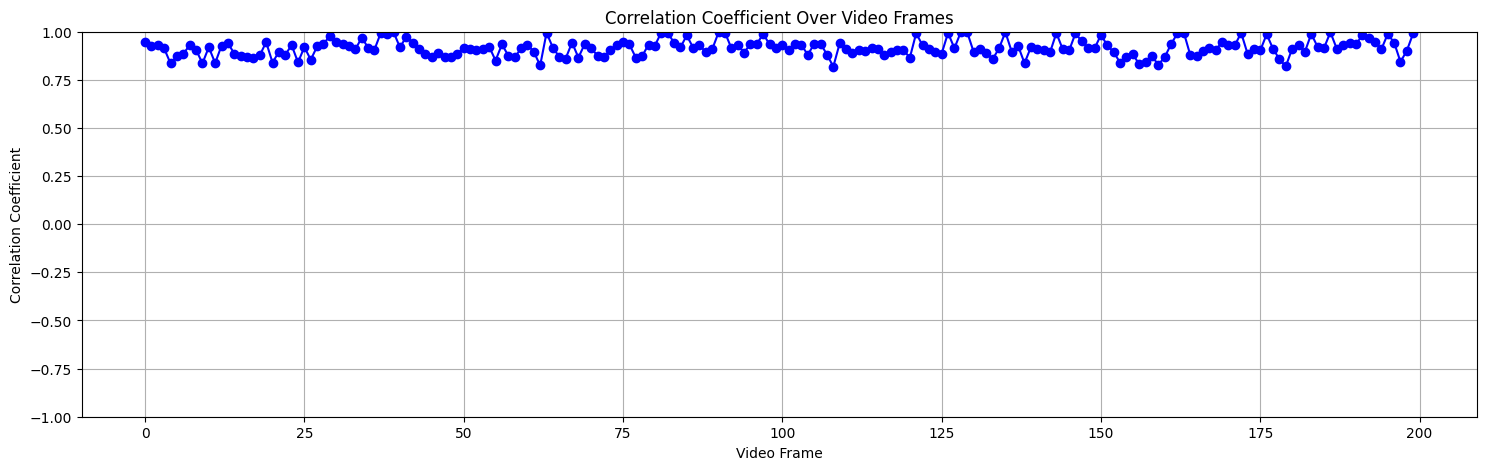

In [11]:
import matplotlib.pyplot as plt

frame = 0 # -1 is synthetic frame
train_val_corr = train_val_corr_orig[frame]
train_val_corr = np.delete(train_val_corr, frame) # remove frame itself (always == 1)
if frame != -1: 
    train_val_corr = np.delete(train_val_corr, len(train_val_corr) - 1) # remove frame itself (always == 1)

# 0th is fra
print(train_val_corr.size())
correlation = train_val_corr


plt.figure(figsize=(18, 5))  # Making the plot wide and not so tall
plt.plot(np.arange(len(train_val_corr)), train_val_corr, marker='o', linestyle='-', color='b')
plt.title('Correlation Coefficient Over Video Frames')
plt.xlabel('Video Frame')
plt.ylabel('Correlation Coefficient')
plt.ylim(-1, 1)
plt.grid(True)

# Save the plot in high resolution
plt.savefig('correlation_timeseries_plot.png', dpi=300)

plt.show()

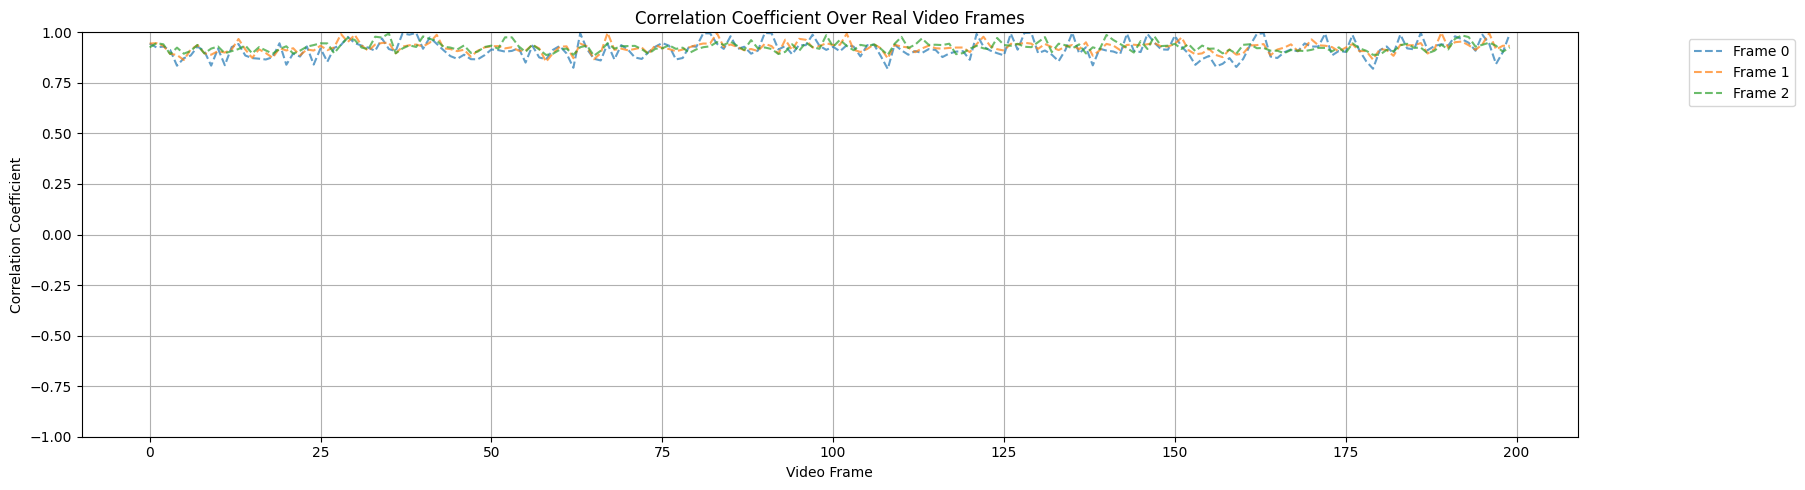

In [13]:
x = 3  # Number of frames to overlay

# Initialize the plot
plt.figure(figsize=(18, 5))  # Making the plot wide and not so tall

for frame in range(x):
    train_val_corr = train_val_corr_orig[frame]
    train_val_corr = np.delete(train_val_corr, frame)  # Remove frame itself (always == 1)
    if frame != -1:
        train_val_corr = np.delete(train_val_corr, len(train_val_corr) - 1)  # Remove last element

    plt.plot(
        np.arange(len(train_val_corr)),
        train_val_corr,
        #marker='o',
        linestyle='--',
        label=f'Frame {frame}',
        alpha=0.7  # Add transparency
    )

# Customize the plot
plt.title('Correlation Coefficient Over Real Video Frames')
plt.xlabel('Video Frame')
plt.ylabel('Correlation Coefficient')
plt.ylim(-1, 1)
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

# Save the plot in high resolution
plt.tight_layout()
plt.savefig('correlation_timeseries_overlay_plot.png', dpi=300)

plt.show()

torch.Size([201])


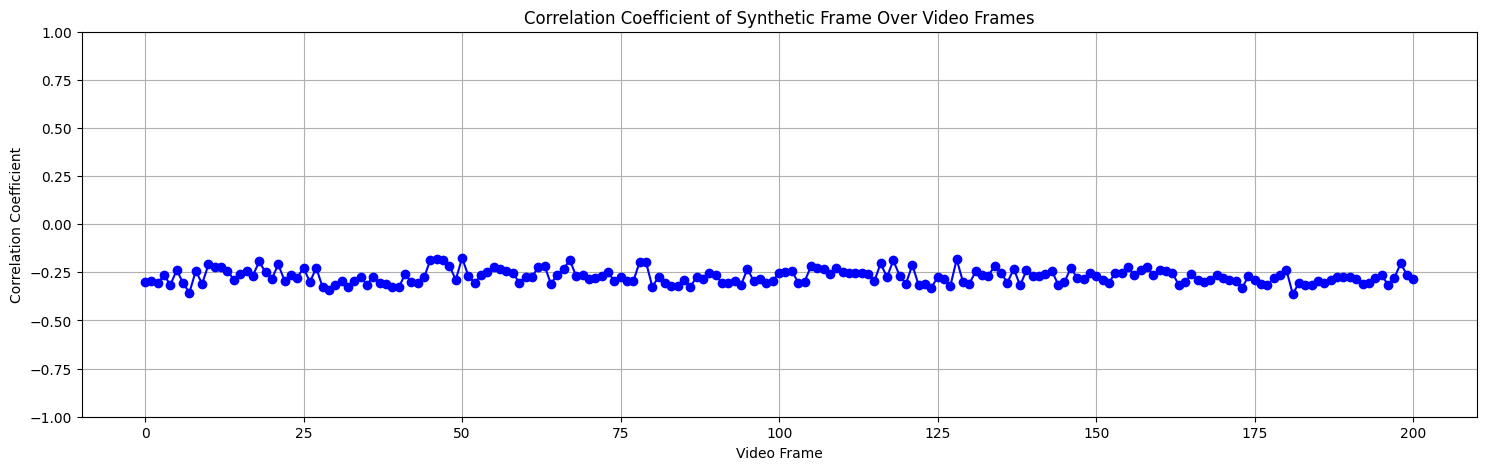

In [14]:
import matplotlib.pyplot as plt

frame = -1 # -1 is synthetic frame
train_val_corr = train_val_corr_orig[frame]
train_val_corr = np.delete(train_val_corr, frame) # remove frame itself (always == 1)
if frame != -1: 
    train_val_corr = np.delete(train_val_corr, len(train_val_corr) - 1) # remove frame itself (always == 1)

# 0th is fra
print(train_val_corr.size())
correlation = train_val_corr


plt.figure(figsize=(18, 5))  # Making the plot wide and not so tall
plt.plot(np.arange(len(train_val_corr)), train_val_corr, marker='o', linestyle='-', color='b')
plt.title('Correlation Coefficient of Synthetic Frame Over Video Frames')
plt.xlabel('Video Frame')
plt.ylabel('Correlation Coefficient')
plt.ylim(-1, 1)
plt.grid(True)

# Save the plot in high resolution
plt.savefig('synthetic_frame_correlation_timeseries_plot.png', dpi=300)

plt.show()

## Looking at synthetic data now

In [15]:
generated_latents_csv      = "/vol/ideadata/at70emic/projects/TMI23/data/diffusion/dynamic/FileList.csv"
generated_latents_basepath = "/vol/ideadata/at70emic/projects/TMI23/data/diffusion/dynamic/Latents"


ds_synth = SimaseUSVideoDataset(phase="training", transform=normalization, latents_csv=training_latents_csv, training_latents_base_path=training_latents_basepath, in_memory=False)


Computing Embeddings for Video 2: 100%|██████████| 1/1 [00:00<00:00, 128.36it/s]


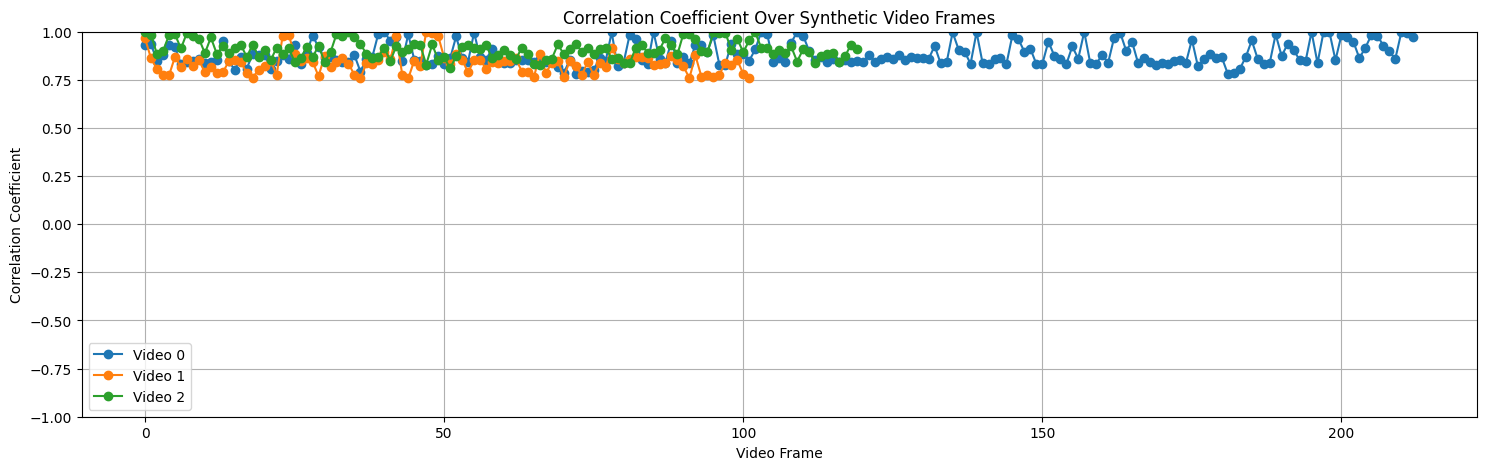

In [17]:
num_videos = 3  # Number of latent synthetic videos to process

# Create a figure for the combined plot
plt.figure(figsize=(18, 5))  # Making the plot wide and not so tall

for video_idx in range(num_videos):
    latent_syn_video = ds_synth[video_idx]

    latents_synth = []
    with torch.no_grad():
        for i in tqdm(np.arange(0, len(latent_syn_video), bs), f"Computing Embeddings for Video {video_idx}"):
            batch = latent_syn_video[i:i+bs].cuda()
            latents_synth.append(net.forward_once(batch))
    latents_synth = torch.cat(latents_synth)
    train_val_corr_orig = torch.corrcoef(torch.cat([latents_synth])).cpu()

    frame = 0  # -1 is synthetic frame
    train_val_corr = train_val_corr_orig[frame]
    train_val_corr = np.delete(train_val_corr, frame)  # remove frame itself (always == 1)
    if frame != -1:
        train_val_corr = np.delete(train_val_corr, len(train_val_corr) - 1)  # remove frame itself (always == 1)

    # Plotting for each video on the same figure
    plt.plot(np.arange(len(train_val_corr)), train_val_corr, marker='o', linestyle='-', label=f'Video {video_idx}')

# Customize the combined plot
plt.title('Correlation Coefficient Over Synthetic Video Frames')
plt.xlabel('Video Frame')
plt.ylabel('Correlation Coefficient')
plt.ylim(-1, 1)
plt.grid(True)
plt.legend()

# Save the combined plot in high resolution
plt.savefig('combined_correlation_timeseries_plot.png', dpi=300)

# Show the combined plot
plt.show()

Computing Train Embeddings for Video 0:   0%|          | 0/1 [00:00<?, ?it/s]

Computing Train Embeddings for Video 4: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


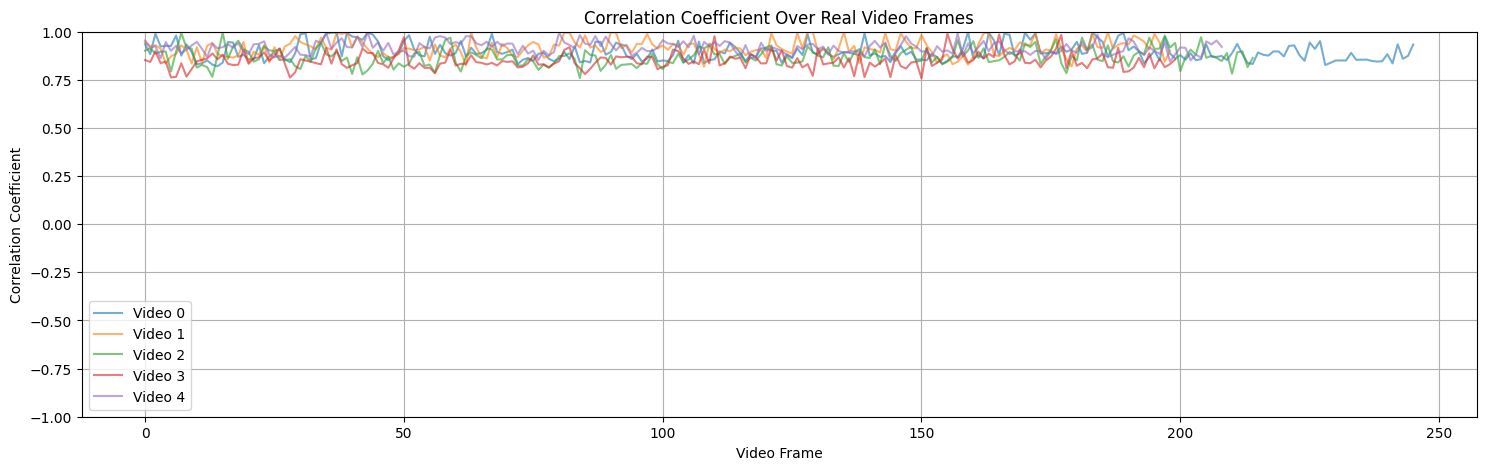

In [18]:

num_videos = 5
plt.figure(figsize=(18, 5))  # Making the plot wide and not so tall

for video_idx in np.arange(num_videos):
    latent_train_video = ds_test[video_idx]

    latents_train = []
    with torch.no_grad():
        for i in tqdm(np.arange(0, len(latent_train_video), bs), f"Computing Train Embeddings for Video {video_idx}"):
            batch = latent_train_video[i:i+bs].cuda()
            latents_train.append(net.forward_once(batch))

    latents_train = torch.cat(latents_train)

    train_val_corr_orig = torch.corrcoef(torch.cat([latents_train])).cpu()

    frame = 0  # -1 is synthetic frame
    train_val_corr = train_val_corr_orig[frame]
    train_val_corr = np.delete(train_val_corr, frame)  # remove frame itself (always == 1)
    if frame != -1:
        train_val_corr = np.delete(train_val_corr, len(train_val_corr) - 1)  # remove frame itself (always == 1)

    # Plotting for each video on the same figure
    plt.plot(np.arange(len(train_val_corr)), train_val_corr, linestyle='-', alpha=0.6, label=f'Video {video_idx}')

# Customize the combined plot
plt.title('Correlation Coefficient Over Real Video Frames')
plt.xlabel('Video Frame')
plt.ylabel('Correlation Coefficient')
plt.ylim(-1, 1)
plt.grid(True)
plt.legend()

# Save the combined plot in high resolution
plt.savefig('combined_correlation_real_timeseries_plot.png', dpi=300)

# Show the combined plot
plt.show()

Computing Embeddings for Video 4:   0%|          | 0/1 [00:00<?, ?it/s]

Computing Train Embeddings for Video 4: 100%|██████████| 1/1 [00:00<00:00, 118.01it/s]


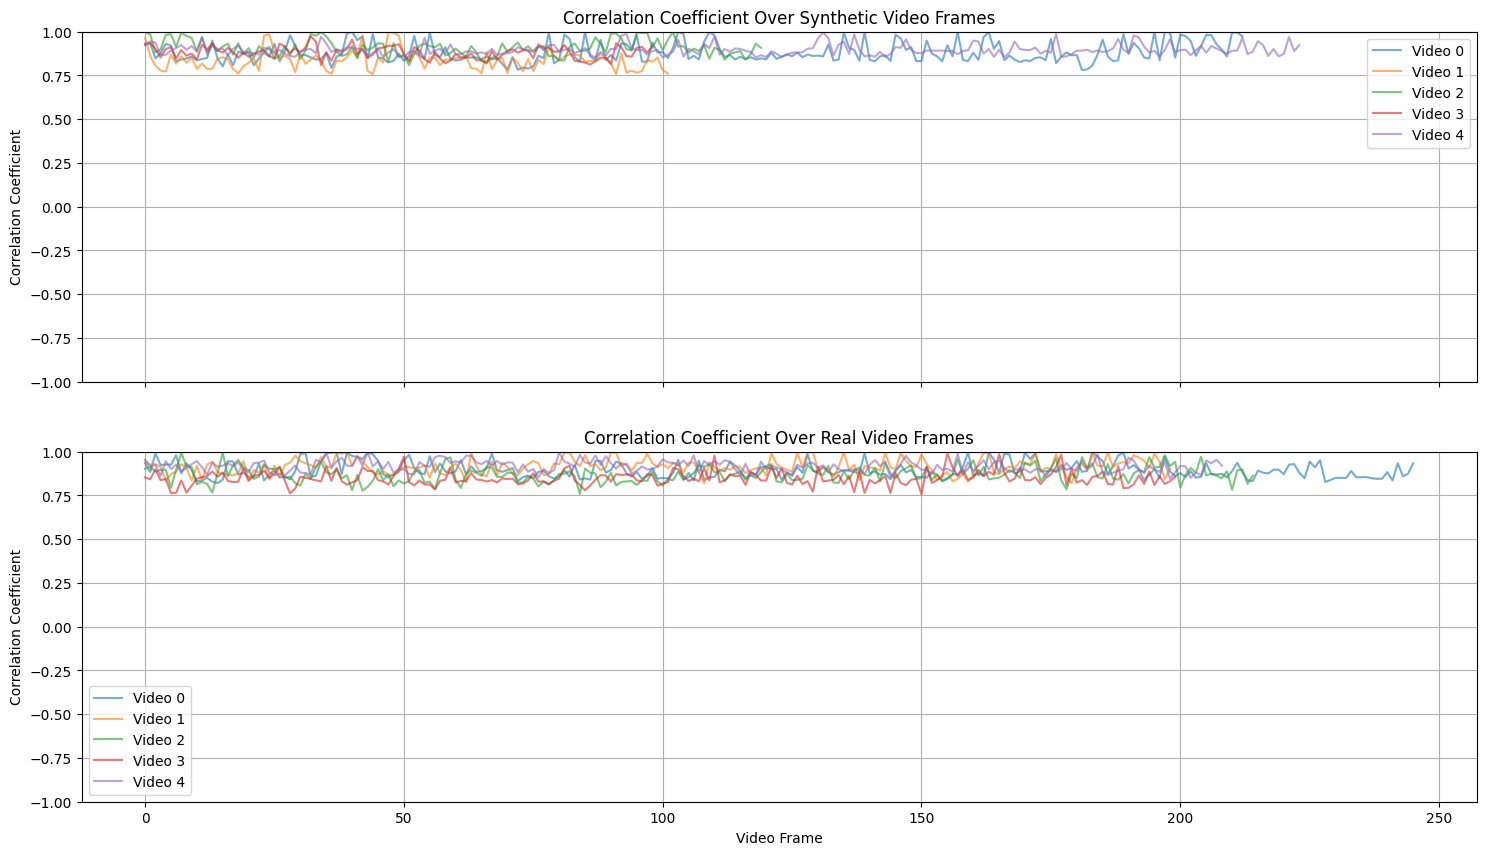

In [19]:
# Number of videos to process for synthetic and real videos
num_synth_videos = 5 
num_real_videos = 5

fig, axs = plt.subplots(2, 1, figsize=(18, 10), sharex=True)  # Creating a figure with two subplots

# Plotting synthetic videos
for video_idx in range(num_synth_videos):
    latent_syn_video = ds_synth[video_idx]

    latents_synth = []
    with torch.no_grad():
        for i in tqdm(np.arange(0, len(latent_syn_video), bs), f"Computing Embeddings for Video {video_idx}"):
            batch = latent_syn_video[i:i+bs].cuda()
            latents_synth.append(net.forward_once(batch))
    latents_synth = torch.cat(latents_synth)
    train_val_corr_orig = torch.corrcoef(torch.cat([latents_synth])).cpu()

    frame = 0  # -1 is synthetic frame
    train_val_corr = train_val_corr_orig[frame]
    train_val_corr = np.delete(train_val_corr, frame)  # remove frame itself (always == 1)
    if frame != -1:
        train_val_corr = np.delete(train_val_corr, len(train_val_corr) - 1)  # remove frame itself (always == 1)

    # Plotting for each video on the first subplot
    axs[0].plot(np.arange(len(train_val_corr)), train_val_corr,  linestyle='-', alpha=0.6,  label=f'Video {video_idx}')

# Customize the first subplot
axs[0].set_title('Correlation Coefficient Over Synthetic Video Frames')
axs[0].set_ylabel('Correlation Coefficient')
axs[0].set_ylim(-1, 1)
axs[0].grid(True)
axs[0].legend()

# Plotting real videos
for video_idx in range(num_real_videos):
    latent_train_video = ds_test[video_idx]

    latents_train = []
    with torch.no_grad():
        for i in tqdm(np.arange(0, len(latent_train_video), bs), f"Computing Train Embeddings for Video {video_idx}"):
            batch = latent_train_video[i:i+bs].cuda()
            latents_train.append(net.forward_once(batch))

    latents_train = torch.cat(latents_train)

    train_val_corr_orig = torch.corrcoef(torch.cat([latents_train])).cpu()

    frame = 0  # -1 is synthetic frame
    train_val_corr = train_val_corr_orig[frame]
    train_val_corr = np.delete(train_val_corr, frame)  # remove frame itself (always == 1)
    if frame != -1:
        train_val_corr = np.delete(train_val_corr, len(train_val_corr) - 1)  # remove frame itself (always == 1)

    # Plotting for each video on the second subplot
    axs[1].plot(np.arange(len(train_val_corr)), train_val_corr, linestyle='-', alpha=0.6, label=f'Video {video_idx}')

# Customize the second subplot
axs[1].set_title('Correlation Coefficient Over Real Video Frames')
axs[1].set_xlabel('Video Frame')
axs[1].set_ylabel('Correlation Coefficient')
axs[1].set_ylim(-1, 1)
axs[1].grid(True)
axs[1].legend()

# Save the combined plot in high resolution
plt.savefig('combined_correlation_synth_and_real_timeseries_plot.png', dpi=300)

# Show the combined plot
plt.show()


# Confusion Matrices 

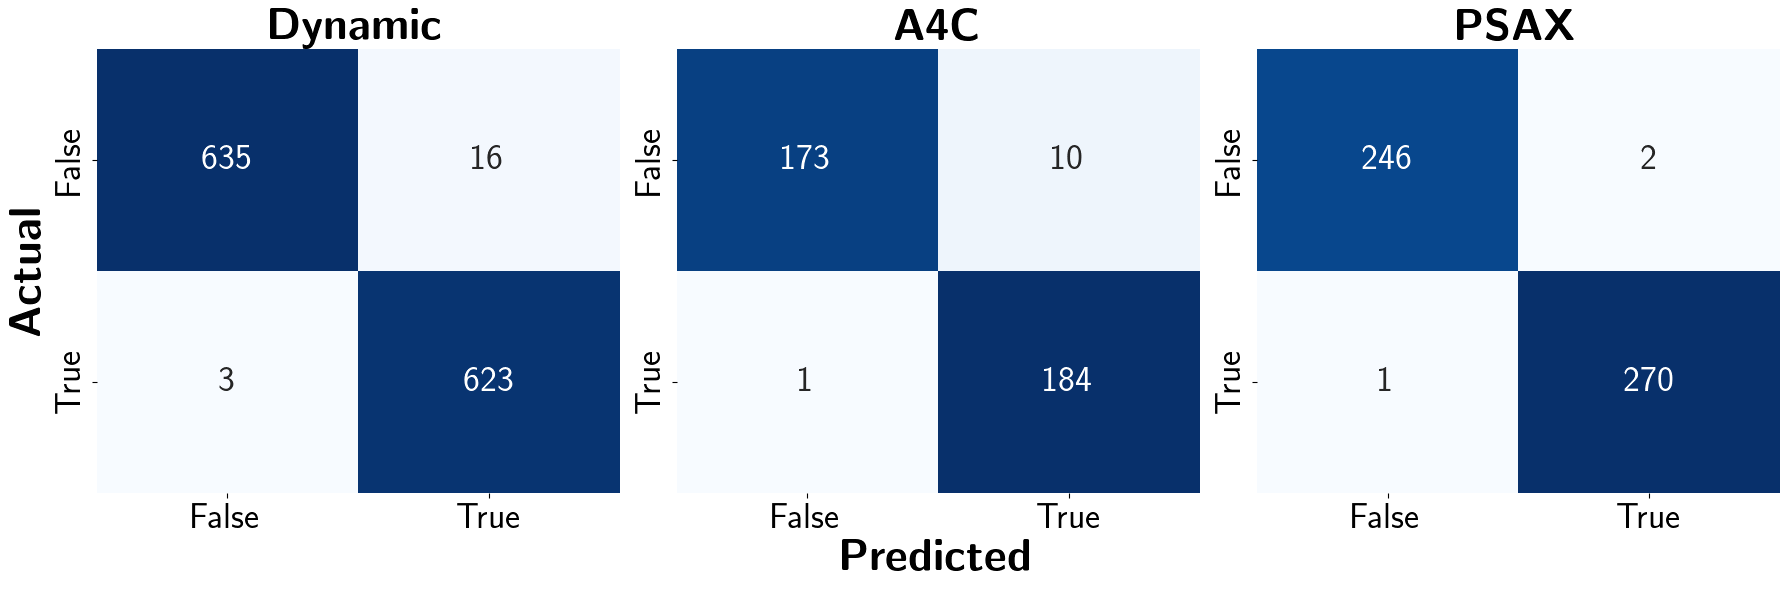

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Enabling LaTeX rendering
plt.rc('text', usetex=True)

# Data # ls 

mode = "LS"
if mode == "IS":
    dynamic = np.array([[650, 1], [1, 625]])
    a4c = np.array([[182, 1], [0, 185]])
    psax = np.array([[247, 1], [0, 271]])
elif mode == "LS":
    dynamic = np.array([[635, 16], [3, 623]])
    a4c = np.array([[173, 10], [1, 184]])
    psax = np.array([[246, 2], [1, 270]])


datasets = [("Dynamic", dynamic), ("A4C", a4c), ("PSAX", psax)]

# Plotting the confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=1)

for ax, (title, matrix), i in zip(axes, datasets, np.arange(len(datasets))):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax, annot_kws={"size": 26})
    if i == 0: 
        ax.set_ylabel(r'\textbf{Actual}', fontsize=32)
    if i == 1: 
        ax.set_xlabel(r'\textbf{Predicted}', fontsize=32)
    ax.set_title(r'\textbf{' + title + '}', fontsize=32)
    ax.xaxis.set_ticklabels([r'False', r'True'], fontsize=26)
    ax.yaxis.set_ticklabels([r'False', r'True'], fontsize=26)

plt.tight_layout()
plt.savefig(f"ConfusionmatricesFinal{mode}.pdf")
plt.show()

In [73]:
# Number of videos to process for synthetic and real videos
num_videos = 1000
synth_cnt = 0
real_cnt = 0
video_length = 113

ref_frame = 0  # -1 is synthetic frame

#synth_cor_timeseries = []
## Plotting synthetic videos
#i = 0
#while synth_cnt < num_videos:
#    latent_syn_video = ds_synth[i]
#    i+=1
#    if len(latent_syn_video) < video_length:
#        continue
#
#    latent_syn_video = latent_syn_video[:video_length]
#    latents_synth = []
#    with torch.no_grad():
#        for i in np.arange(0, len(latent_syn_video), bs):
#            batch = latent_syn_video[i:i+bs].cuda()
#            latents_synth.append(net.forward_once(batch))
#    latents_synth = torch.cat(latents_synth)
#    train_val_corr_full = torch.corrcoef(torch.cat([latents_synth])).cpu()
#    train_val_corr_frame = np.delete(train_val_corr_full[ref_frame], ref_frame)
#    synth_cor_timeseries.append(train_val_corr_frame)
#    synth_cnt += 1

real_cor_timeseries = []
# Plotting synthetic videos
j = 0
while real_cnt < num_videos:
    latent_real_video = ds_train[j]
    j+=1
    if len(latent_real_video) < video_length:
        continue

    latent_real_video = latent_real_video[:video_length]
    latents_real = []
    with torch.no_grad():
        for i in np.arange(0, len(latent_real_video), bs):
            batch = latent_real_video[i:i+bs].cuda()
            latents_real.append(net.forward_once(batch))
    latents_real = torch.cat(latents_real)
    train_val_corr_orig = torch.corrcoef(torch.cat([latents_real])).cpu()
    train_val_corr_frame = np.delete(train_val_corr_orig[ref_frame], ref_frame)
    real_cor_timeseries.append(train_val_corr_frame)
    real_cnt += 1

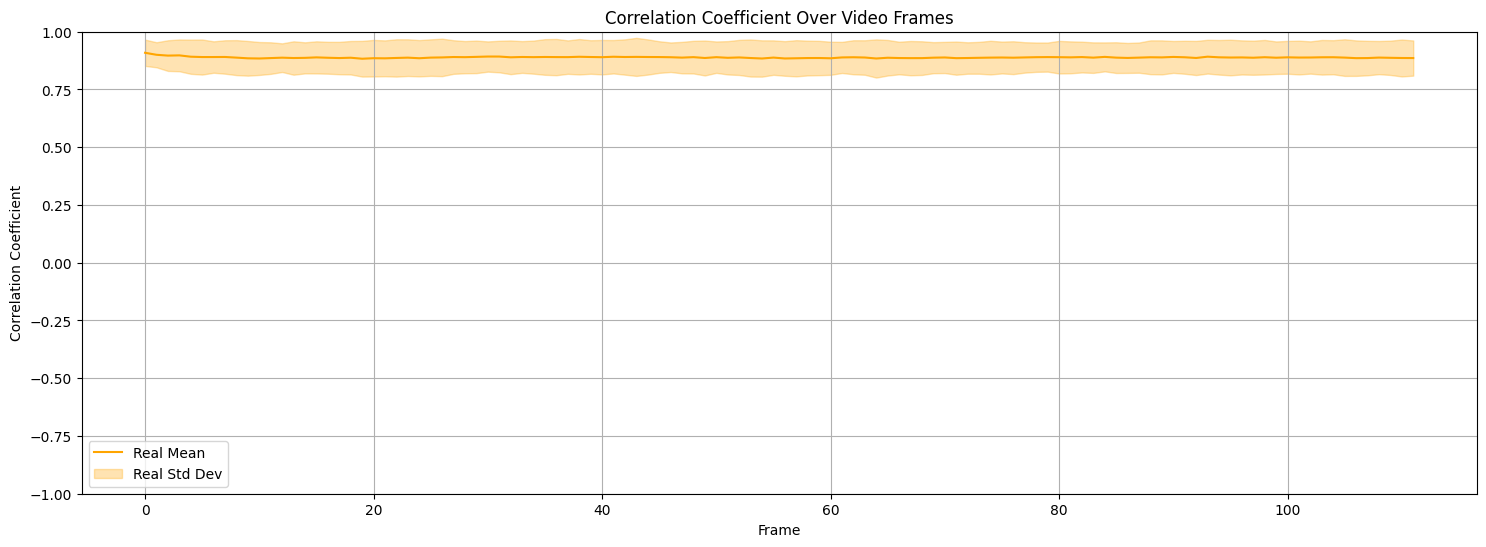

In [74]:
#synth_cor_timeseries = np.array(synth_cor_timeseries)
real_cor_timeseries = np.array(real_cor_timeseries)

# Compute mean and standard deviation
#synth_mean = np.mean(synth_cor_timeseries, axis=0)
#synth_std = np.std(synth_cor_timeseries, axis=0)

real_mean = np.mean(real_cor_timeseries, axis=0)
real_std = np.std(real_cor_timeseries, axis=0)

# Time axis (assuming all time series are of the same length)
time_axis = np.arange(real_mean.shape[0])

# Create the plot
fig, ax = plt.subplots(figsize=(18, 6))
# Plot the synthetic data
#ax.plot(time_axis, synth_mean, label='Synthetic Mean', color='blue')
#ax.fill_between(time_axis, synth_mean - synth_std, synth_mean + synth_std, color='blue', alpha=0.3, label='Synthetic Std Dev')

# Plot the real data
ax.plot(time_axis, real_mean, label='Real Mean', color='orange')
ax.fill_between(time_axis, real_mean - real_std, real_mean + real_std, color='orange', alpha=0.3, label='Real Std Dev')

# Customize the plot
ax.set_title('Correlation Coefficient Over Video Frames')
ax.set_ylabel('Correlation Coefficient')
ax.set_xlabel('Frame')
ax.set_ylim(-1, 1)
ax.grid(True)
ax.legend()

plt.show()